<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc" style="margin-top: 1em;"><ul class="toc-item"></ul></div>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import os
from tqdm import tqdm
from scipy import signal, interpolate, fftpack

LEFT_PATH = 'data/bb_left_forearm_csv/'
RIGHT_PATH = 'data/bb_right_forearm_csv/'
PATH = 'data/bb_capture/'

MA_WINDOW = 5

In [2]:
files = next(os.walk(PATH))[2]
filenames = []
bb_dfs = []
left_bb_dfs = []
right_bb_dfs = []

for id_, filename in tqdm(enumerate(files), total=len(files)):
    filenames.append(filename)
    bb_df = pd.read_csv(PATH + filename)
    lb = float(bb_df.head(1)['timestamp'])
    rb = float(bb_df.tail(1)['timestamp'])
    
    bb_dfs.append(bb_df)    
    
    df = pd.read_csv(LEFT_PATH + 'leftarm_' + filename)
    df.drop('key', axis=1, inplace=True)
    df = df[(df['timestamp'] >= lb) & (df['timestamp'] <= rb)]
    left_bb_dfs.append(df)   
    
    df = pd.read_csv(RIGHT_PATH + 'rightarm_' + filename)
    df.drop('key', axis=1, inplace=True)
    df = df[(df['timestamp'] >= lb) & (df['timestamp'] <= rb)]
    right_bb_dfs.append(df)       

100%|██████████| 3/3 [00:10<00:00,  3.42s/it]


In [16]:
def FFT(xs):
    n = 2 ** 5

    fs = 1 / 2
    ps = 1 / fs

    spectrum = fftpack.fft(xs)
    spectrum_ss = 2 / n * np.abs(spectrum[0:n // 2])

    freq = np.linspace(0, fs / 2, int(n // 2))
    
    fft_df = pd.DataFrame(data={
        'freq': freq,
        'spectrum': spectrum_ss
    })
    return fft_df

In [17]:
for i in range(len(bb_dfs)):
    left_bb_dfs[i]['rms'] = (
        left_bb_dfs[i]['imu_ax'] * left_bb_dfs[i]['imu_ax'] +
        left_bb_dfs[i]['imu_ay'] * left_bb_dfs[i]['imu_ay'] +
        left_bb_dfs[i]['imu_az'] * left_bb_dfs[i]['imu_az']
    ).apply(lambda x: math.sqrt(x))

    right_bb_dfs[i]['rms'] = (
        right_bb_dfs[i]['imu_ax'] * right_bb_dfs[i]['imu_ax'] +
        right_bb_dfs[i]['imu_ay'] * right_bb_dfs[i]['imu_ay'] +
        right_bb_dfs[i]['imu_az'] * right_bb_dfs[i]['imu_az']
    ).apply(lambda x: math.sqrt(x))

bb_capture_capture_2018_03_23_12_54_35.csv


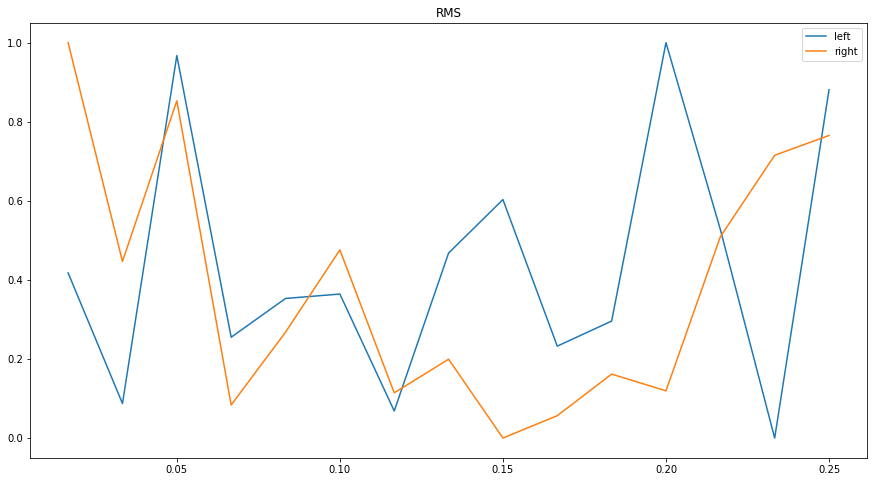

bb_capture_capture_2018_03_23_12_51_28.csv


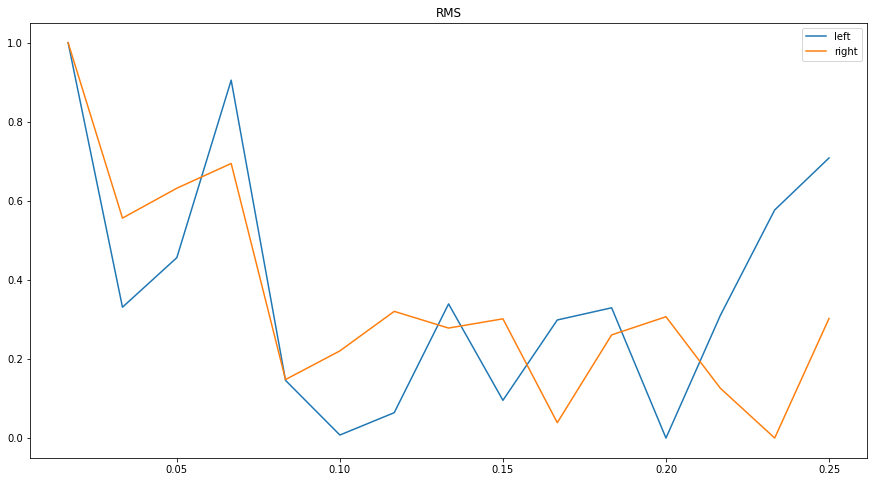

bb_capture_capture_2018_03_23_12_58_32.csv


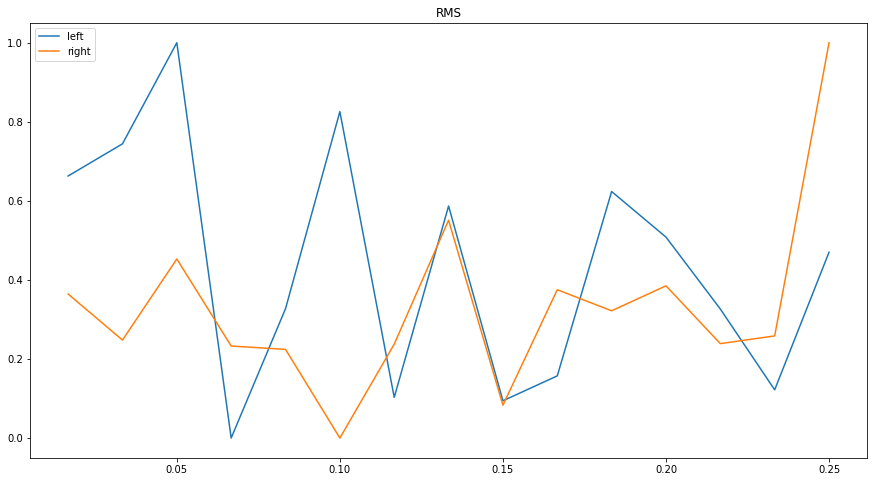

In [18]:
for i in range(len(bb_dfs)):
    left_df = left_bb_dfs[i].rolling(
        window=MA_WINDOW, center=True).mean().dropna()
    right_df = right_bb_dfs[i].rolling(
        window=MA_WINDOW, center=True).mean().dropna()

    print(filenames[i])

    plt.figure(figsize=(15, 8))

    fft_df = FFT(left_df['rms'])
    fft_df = fft_df[fft_df['freq'] >= 0.01]
    fft_df['spectrum'] = (fft_df['spectrum'] - fft_df['spectrum'].min()) / (
        fft_df['spectrum'].max() - fft_df['spectrum'].min())

    plt.plot(fft_df['freq'], fft_df['spectrum'], label='left')

    fft_df = FFT(right_df['rms'])
    fft_df = fft_df[fft_df['freq'] >= 0.01]
    fft_df['spectrum'] = (fft_df['spectrum'] - fft_df['spectrum'].min()) / (
        fft_df['spectrum'].max() - fft_df['spectrum'].min())

    plt.plot(fft_df['freq'], fft_df['spectrum'], label='right')

    plt.legend()
    plt.title('RMS')
    plt.show()